In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

**LOADING DATA**

In [8]:
dataset = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')

**EDA**

In [9]:
dataset.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
dataset.shape

(3130272, 8)

In [11]:

dataset.tail(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3130270,1513522440,19250.00,19277.32,19237.96,19237.96,7.130431,137264.84337,19250.566489
3130271,1513522500,19255.84,19255.84,19215.00,19219.13,9.945457,19.00000,NaN


**DATA CLEANING**

In [12]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill() #clean the data by filling the NaNs with the last available values

In [13]:
dataset=dataset.drop(columns=['Timestamp']) #The Timestamp column is not useful for modeling and is dropped from the dataset

**Preparing the data for classification.**
we will create the target variable for our model.
This is the column that will indicate whether the trading signal is buy or sell.
We define the short-term price as the 10-day rolling average and the long-
term price as the 60-day rolling average.
We attach a label of 1 (0) if the short-term price is higher (lower) than the long-term price.



In [20]:
# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['Close'].rolling(window=10, min_periods=1,\
center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['Close'].rolling(window=60, min_periods=1,\
center=False).mean()
# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] >
dataset['long_mavg'], 1.0, 0.0)

**FEATURE ENGINEERING**

In [21]:
#calculation of exponential moving average
def EMA(df, n):
  EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_'\
  + str(n))
  return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):
  M = df.diff(n - 1)
  N = df.shift(n - 1)
  ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
  return ROC
dataset['ROC10'] = ROC(dataset['Close'], 10)
dataset['ROC30'] = ROC(dataset['Close'], 30)

#calculation of price momentum
def MOM(df, n):
  MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
  return MOM
dataset['MOM10'] = MOM(dataset['Close'], 10)
dataset['MOM30'] = MOM(dataset['Close'], 30)

#calculation of relative strength index
def RSI(series, period):
  delta = series.diff().dropna()
  u = delta * 0
  d = u.copy()
  u[delta > 0] = delta[delta > 0]
  d[delta < 0] = -delta[delta < 0]
  u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
  u = u.drop(u.index[:(period-1)])
  d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
  d = d.drop(d.index[:(period-1)])
  rs = u.ewm(com=period-1, adjust=False).mean() / \
  d.ewm(com=period-1, adjust=False).mean()
  return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['Close'], 10)
dataset['RSI30'] = RSI(dataset['Close'], 30)
dataset['RSI200'] = RSI(dataset['Close'], 200)

#calculation of stochastic osillator.
def STOK(close, low, high, n):
  STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - \
  low.rolling(n).min())) * 100
  return STOK

def STOD(close, low, high, n):
  STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - \
  low.rolling(n).min())) * 100
  STOD = STOK.rolling(3).mean()
  return STOD
dataset['%K10'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%D10'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 10)
dataset['%K30'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%D30'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 30)
dataset['%K200'] = STOK(dataset['Close'], dataset['Low'], dataset['High'], 200)
dataset['%D200'] = STOD(dataset['Close'], dataset['Low'], dataset['High'], 200)

#calculation of moving average
def MA(df, n):
  MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_'\
  + str(n))
  return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)

**DATA VISUALIZATION**

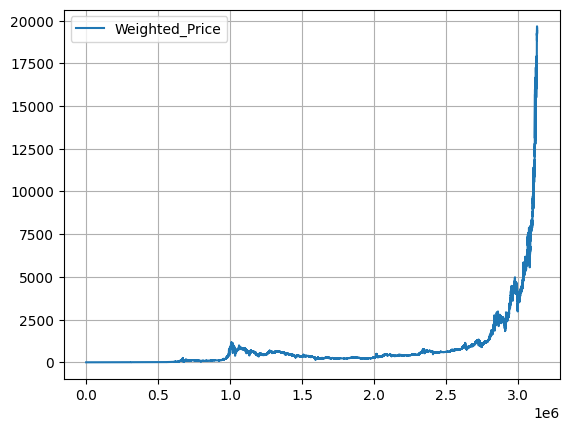

In [22]:
dataset[['Weighted_Price']].plot(grid=True)
plt.show()

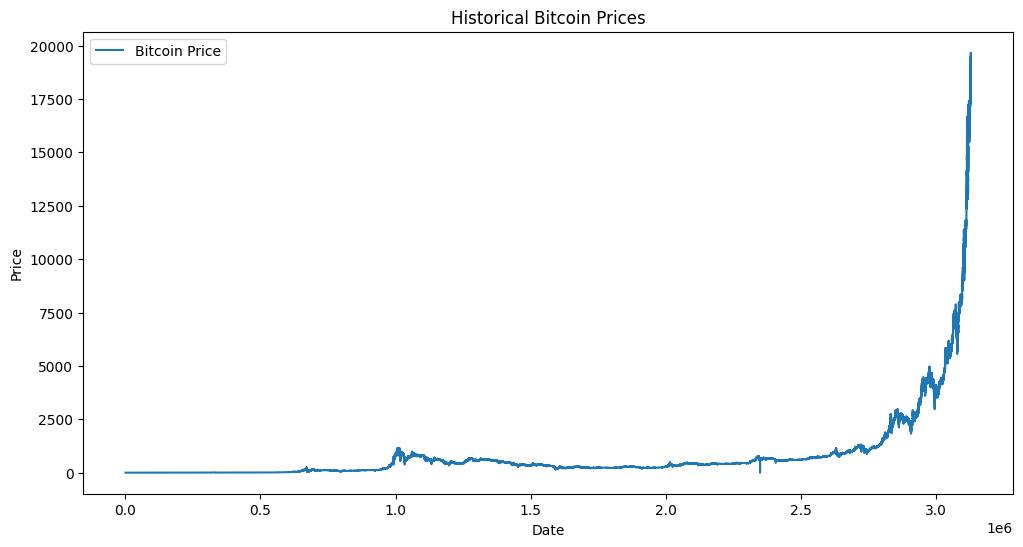

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(dataset['Close'], label='Bitcoin Price')
plt.title('Historical Bitcoin Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**EVALUATE ALGO & MODEL**

TRAIN-TEST SPLIT

In [24]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation =\
train_test_split(X, Y, test_size=validation_size, random_state=1)

In [25]:
# test options for classification
num_folds = 10
scoring = 'accuracy'

**MODELS**

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier


models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
# Ensemble Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

**MODEL TUNING & GRID SEARCH**

In [32]:
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, \
criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds,shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, \
scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_,\
grid_result.best_params_))

KeyboardInterrupt: 

In [34]:
from sklearn.metrics import accuracy_score
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10)
#model = LogisticRegression()
model.fit(X_train, Y_train)
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))

0.9097


**Variable intuition/feature importance.**

Text(0.5, 0, 'Variable Importance')

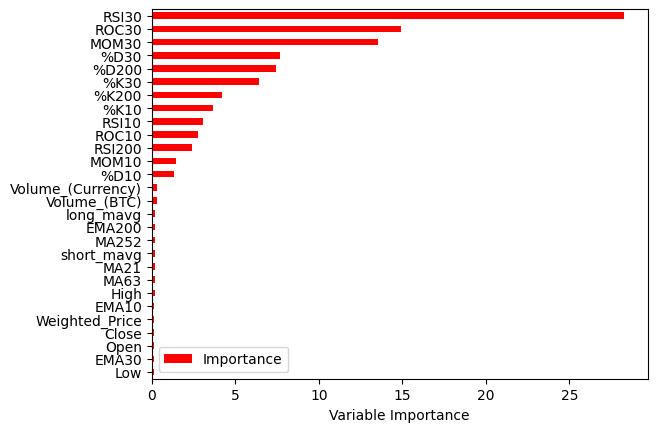

In [35]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100},\
index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', \
color='r' )
plt.xlabel('Variable Importance')

**Backtesting results.**

<Axes: >

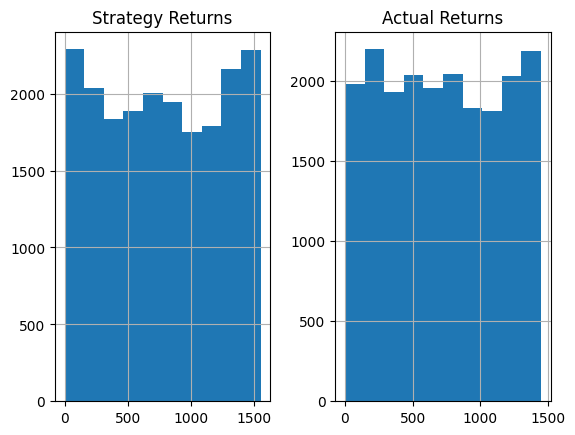

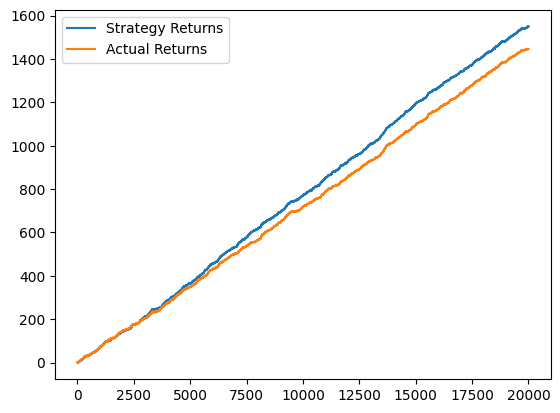

In [36]:
backtestdata = pd.DataFrame(index=X_validation.index)
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] *\
backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * \
backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()